In [1]:
import os
import glob
import shutil
from functools import partial
from matplotlib.colors import Normalize, CenteredNorm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
#plt.style.use('seaborn-talk') 
plt.style.use('seaborn-v0_8-talk')
import cmocean
import datetime
import cartopy.crs as ccrs
import numpy as np
import dask
from dask.distributed import LocalCluster, Client, progress
import netCDF4 as nc
import xarray as xr

In [2]:
# monthly files for medium resolution (0.5 deg atm, 0.1 deg ocn)
cdir = '/projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f05_t12/output/'
gdir = '/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001/'
camc = cdir+'atm/hist/spinup_pd_maxcores_f05_t12.cam2.h0.????-??.nc'
icec = cdir+'ice/hist/spinup_pd_maxcores_f05_t12.001.cice.h.????-??.nc'
clmc = cdir+'lnd/hist/spinup_pd_maxcores_f05_t12.clm2.h0.????-??.nc'
popc = cdir+'ocn/hist/spinup_pd_maxcores_f05_t12.pop.h.????-??.nc'
camg = gdir+'atm/hist/mres_b.e10.B2000_CAM5.f05_t12.001.cam2.h0.????-??.nc'
iceg = gdir+'ice/hist/mres_b.e10.B2000_CAM5.f05_t12.001.cice.h.????-??.nc'
clmg = gdir+'lnd/hist/mres_b.e10.B2000_CAM5.f05_t12.001.clm2.h0.????-??.nc'
popg = gdir+'ocn/hist/mres_b.e10.B2000_CAM5.f05_t12.001.pop.h.????-??.nc'
aerg = gdir+'strataero/ozone_strataero_1999-2100_SSP585_CAMfeedback.nc'
volg = gdir+'volcaero/volcaero_1999-2100_SSP585_CAMfeedback.nc'

In [3]:
# run this instead for local testing with a subset of the data
camc = '/Users/jasperdejong/Documents/PhD/Geo/sai-git/sai/data/deg5/spinup_pd_maxcores_5deg.cam2.h0.????-??.nc'
camg = '/Users/jasperdejong/Documents/PhD/Geo/sai-git/sai/data/deg5/mres_b.e10.B2000_CAM5.5deg.001.cam2.h0.????-??.nc'
icec=''; iceg=''; clmc=''; clmg=''; popc=''; popg=''; aero=''; volc=''

# # to create the above data on Snellius:
# outdir = '~/copy240704/'
# filescnt = sorted(glob.glob(camc.replace('????','0194')) + glob.glob(camc.replace('????','0297')))
# filesgeo = sorted(glob.glob(camg.replace('????','2097')))
# if not os.path.exists(outdir):
#     os.mkdir(outdir)
# sh = slice(None,None,10)# select every tenth horizontal grid point
# sv = slice(None,None,3) # select every third vertical level
# for files in (filescnt, filesgeo):
#     for file in files:
#         name = os.path.basename(file).replace('f05_t12','5deg')
#         with xr.open_dataset(file) as ds:
#             dss = ds.isel(lev=sv,ilev=sv,lat=sh,slat=sh,lon=sh,slon=sh)
#             dss.to_netcdf(os.path.join(outdir,name))
#         print(name)

In [ ]:
# initiate dask cluster for parallel computing
cluster = LocalCluster(n_workers=2, threads_per_worker=8, memory_limit="14GiB")
client = Client(cluster)
cluster, client

In [4]:
def center_time(ds):
    """set time stamps to center of time_bnds"""
    time = ('time', ds.time_bnds.mean('nbnd').data, ds.time.attrs)
    ds = ds.assign_coords({'ctime':time}).swap_dims({'time':'ctime'})
    return ds.drop_vars('time').rename({'ctime':'time'})


def shift_time(ds, days):
    """shift time of dataset"""
    dt = datetime.timedelta(days=days)
    ds = ds.assign(time_bnds=(ds.time_bnds.dims,(ds.time_bnds.compute()+dt).data,ds.time_bnds.attrs))
    return ds.assign(time=(ds.time.dims,(ds.time+dt).data,ds.time.attrs))

In [18]:
0.038*len(glob.glob(camc))

55.176

In [6]:
open_mfdataset = partial(xr.open_mfdataset, concat_dim='time', combine='nested', data_vars='minimal',
                         coords='minimal', join='exact', compat='override')

In [5]:
%%time
ds = xr.open_mfdataset(camc, data_vars="minimal", coords="minimal", join="exact", compat="override")

CPU times: user 3min 32s, sys: 8.7 s, total: 3min 41s
Wall time: 4min 44s


In [85]:
ds.close()

In [88]:
%%time
!python /Users/jasperdejong/Documents/PhD/Geo/sai-git/sai/scripts/temperaturegradients.py

CPU times: user 139 ms, sys: 120 ms, total: 258 ms
Wall time: 11.1 s


In [82]:
ds = xr.open_dataset('mres.sai2050.tempgradients.nc')

In [84]:
ds.T0.compute()

<xarray.DataArray 'T0' (year: 1)>
array([288.17468914])
Coordinates:
  * year     (year) int64 2097
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [76]:
ds.close()

In [72]:
ds.close()

In [7]:
%%time
cam = {
    'cnt': shift_time(center_time(open_mfdataset(camc)), days=365*1800),
    'geo': center_time(open_mfdataset(camg)),
}

CPU times: user 6min 9s, sys: 16.8 s, total: 6min 26s
Wall time: 13min 19s


In [ ]:
ice = {
    'cnt': center_time(xr.open_mfdataset(icec)),
    'geo': center_time(xr.open_mfdataset(iceg)),
}

In [ ]:
clm = {
    'cnt': center_time(xr.open_mfdataset(clmc)),
    'geo': center_time(xr.open_mfdataset(clmg)),
}

In [ ]:
pop = {
    'cnt': center_time(xr.open_mfdataset(popc, parallel=True)),
    'geo': center_time(xr.open_mfdataset(popg, parallel=True)),
}

### sea ice

In [12]:
cluster = LocalCluster()
cluster

LocalCluster(9ab56a6f, 'tcp://127.0.0.1:40543', workers=4, threads=16, memory=28.00 GiB)

In [13]:
client = Client(cluster)

In [14]:
print(cluster)

LocalCluster(9ab56a6f, 'tcp://127.0.0.1:40543', workers=4, threads=16, memory=28.00 GiB)


In [15]:
print(client)

<Client: 'tcp://127.0.0.1:40543' processes=4 threads=16, memory=28.00 GiB>


In [ ]:
lat1, lon1 = 70.932928151704104, -123.24235946618927%360
lat2, lon2 = -59.662297277421509, -149.54999999999998%360
dlat, dlon = 5, 5
box1 = {
    'lat':slice(lat1-dlat, lat1+dlat), 'slat':slice(lat1-dlat, lat1+dlat), 
    'lon':slice(lon1-dlon, lon1+dlon), 'slon':slice(lon1-dlon, lon1+dlon)
}
box2 = {
    'lat':slice(lat2-dlat, lat2+dlat), 'slat':slice(lat2-dlat, lat2+dlat), 
    'lon':slice(lon2-dlon, lon2+dlon), 'slon':slice(lon2-dlon, lon2+dlon)
}

ds1 = ds.sel(box1)
ds2 = ds.sel(box2)

In [8]:
%time
ds = xr.open_mfdataset(files, parallel=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


In [18]:
ds = ds.chunk({'time':-1,'nj':48,'ni':72,'nvertices':1})

In [13]:
lat1, lon1 = 70.932928151704104, -123.24235946618927%360
lat2, lon2 = -59.662297277421509, -149.54999999999998%360
dlat, dlon = 5, 5
dss = ds.stack(n=('nj','ni'))
dss1 = dss.where((dss.TLAT>lat1-dlat) & (dss.TLAT<lat1+dlat) & (dss.TLON>lon1-dlon) & (dss.TLON<lon1+dlon), np.nan).dropna('n')
dss1

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 76.48 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-04-10 10:36:11,601 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 5.75 GiB -- Worker memory limit: 7.00 GiB
2024-04-10 10:36:16,631 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 5.64 GiB -- Worker memory limit: 7.00 GiB
2024-04-10 10:36:42,298 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 5.68 GiB -- Worker memory limit: 7.00 GiB
2024-04-10 10:36:44,991 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 5.68 GiB -- Worker memory limit: 7.00 GiB
2024-04-10 10:37:04,808 - distributed.worker.memory - WARNING - Worker 

KilledWorker: Attempted to run task ('where-f75cc946b8896b8ba2230b87c1975b85', 0, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:42553. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2024-04-10 10:37:30,632 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.97 GiB -- Worker memory limit: 7.00 GiB
2024-04-10 10:37:31,892 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 5.60 GiB -- Worker memory limit: 7.00 GiB


In [ ]:
dss1.to_netcdf(outdir+'ice_box1.nc')

In [55]:
lat1, lon1 = 70.932928151704104, -123.24235946618927%360
lat2, lon2 = -59.662297277421509, -149.54999999999998%360
dlat, dlon = 0.3, 0.3

def stack_and_select(file):
    print(f'\r{file}')
    with xr.open_dataset(file) as ds:
        dss = ds.stack(n=('nj','ni'))
        dss1 = dss.where((dss.TLAT>lat1-dlat) & (dss.TLAT<lat1+dlat) & (dss.TLON>lon1-dlon) & (dss.TLON<lon1+dlon), np.nan).dropna('n')
        dss1.load()
        # dss2 = dss.where((dss.TLAT>lat2-dlat) & (dss.TLAT<lat2+dlat) & (dss.TLON>lon2-dlon) & (dss.TLON<lon2+dlon), np.nan).dropna('n')
        # dss2.load()
        return dss1 #, dss2

st

In [64]:
dss = xr.open_dataset(files[0])
dss = ds.copy().stack(n=('nj','ni'))
dss1 = dss.where((dss.TLAT>lat1-dlat) & (dss.TLAT<lat1+dlat) & (dss.TLON>lon1-dlon) & (dss.TLON<lon1+dlon), np.nan).dropna('n')
dss1.load()
dss2 = dss.where((dss.TLAT>lat2-dlat) & (dss.TLAT<lat2+dlat) & (dss.TLON>lon2-dlon) & (dss.TLON<lon2+dlon), np.nan).dropna('n')
dss2.load()

<xarray.Dataset> Size: 8B
Dimensions:        (time: 1, d2: 2, n: 0, nvertices: 4)
Coordinates:
  * time           (time) object 8B 2045-02-01 00:00:00
    TLON           (n) float32 0B 
    TLAT           (n) float32 0B 
    ULON           (n) float32 0B 
    ULAT           (n) float32 0B 
  * n              (n) object 0B MultiIndex
  * nj             (n) int64 0B 
  * ni             (n) int64 0B 
Dimensions without coordinates: d2, nvertices
Data variables: (12/128)
    time_bounds    (time, d2, n) object 0B 
    tmask          (n) float32 0B 
    tarea          (n) float32 0B 
    uarea          (n) float32 0B 
    dxt            (n) float32 0B 
    dyt            (n) float32 0B 
    ...             ...
    faero_atm001   (time, n) float32 0B 
    faero_atm002   (time, n) float32 0B 
    faero_atm003   (time, n) float32 0B 
    faero_ocn001   (time, n) float32 0B 
    faero_ocn002   (time, n) float32 0B 
    faero_ocn003   (time, n) float32 0B 
Attributes:
    title:        mres_b.e10.B2000_CAM5.f05_t12.001
    contents:     Diagnostic and Prognostic Variables
    source:       sea ice model: Community Ice Code (CICE)
    comment:      All years have exactly 365 days
    comment2:     File written on model date 20450201
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2023-11-22 at 13:18:05.3

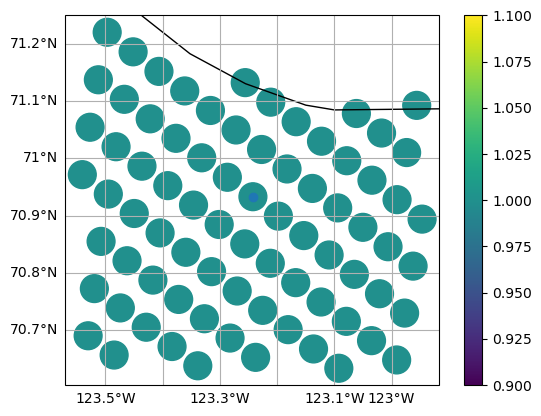

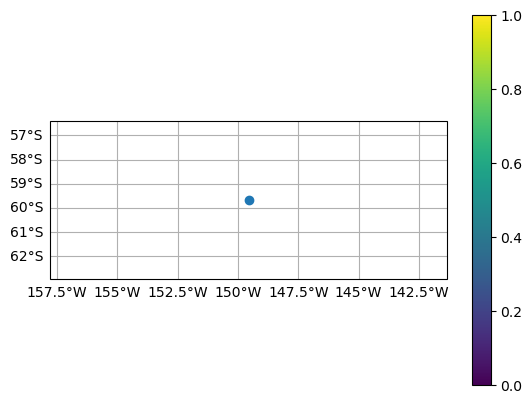

In [65]:
%matplotlib inline


ax = plt.axes(projection=ccrs.PlateCarree())
p = ax.scatter(dss1.TLON, dss1.TLAT, s=400, c=dss1.ice_present)
plt.scatter(lon1,lat1)
plt.colorbar(p)
ax.gridlines(draw_labels=['left','bottom'])
ax.coastlines('10m')
plt.show()

ax = plt.axes(projection=ccrs.PlateCarree())
p = ax.scatter(dss2.TLON, dss2.TLAT, s=400, c=dss2.ice_present)
plt.scatter(lon2,lat2)
plt.colorbar(p)
ax.gridlines(draw_labels=['left','bottom'])
ax.coastlines('10m')
plt.show()

In [55]:
ds1.close()
ds2.close()

In [ ]:
ds.unstack(

In [ ]:
ds1

## CAM H0

In [8]:
%%time
TASGAg = cam['geo'].TREFHT.weighted(cam['geo'].gw).mean(('lat','lon')).groupby('time.year').mean('time').compute()
TASGAc = cam['cnt'].TREFHT.weighted(cam['cnt'].gw).mean(('lat','lon')).groupby('time.year').mean('time').compute()

CPU times: user 15.1 s, sys: 3.67 s, total: 18.7 s
Wall time: 5min 38s


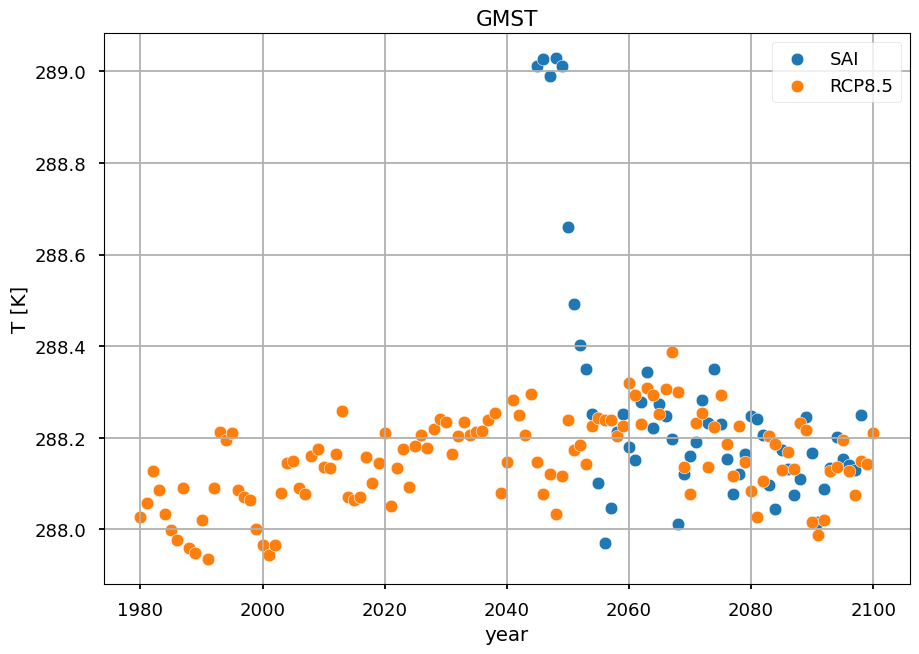

In [9]:
TASGAg.plot.scatter(label='SAI')
TASGAc.plot.scatter(label='RCP8.5')
plt.grid()
plt.title('GMST'); plt.ylabel('T [K]'); plt.xlabel('year')
plt.legend()

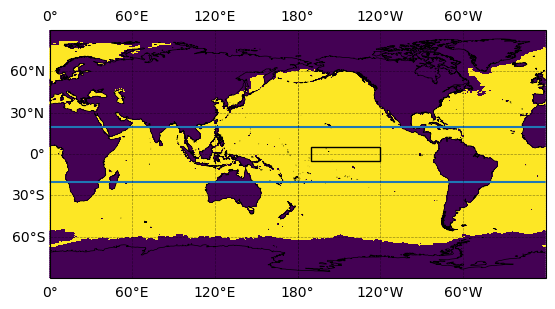

In [12]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ax.set_global()
ax.pcolormesh(cam['geo'].lon, cam['geo'].lat, cam['geo'].OCNFRAC.isel(time=0)==1, transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m', linewidth=.5, color='black') # add map

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, color='k',
                  linestyle='--')
ax.add_patch(mpatches.Rectangle(xy=[-170, -5], width=50, height=10,
                                facecolor='none', edgecolor='k',
                                transform=ccrs.PlateCarree()))
ax.axhline(-20); ax.axhline(20)

In [13]:
camh0ds_1 = cam['geo'].sel(lon=slice(190,240), lat=slice(-5,5))
camh0ds_2 = cam['geo'].sel(lat=slice(-20,20))

Text(0.5, 1.0, 'grid weights')

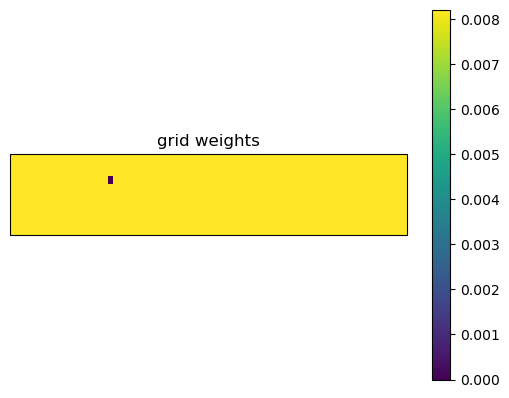

In [14]:
weights_1 = camh0ds_1.gw * (camh0ds_1.OCNFRAC==1)
weights_2 = camh0ds_2.gw * (camh0ds_2.OCNFRAC==1)
ax=plt.axes(projection=ccrs.PlateCarree())
weights_1.isel(time=0).plot.pcolormesh(ax=ax)
#ax.coastlines()
ax.set_title('grid weights')

In [15]:
SST_1 = camh0ds_1.TS.weighted(weights_1).mean(('lat','lon')).compute()
SST_2 = camh0ds_2.TS.weighted(weights_2).mean(('lat','lon')).compute()

Exception ignored in: <function CachingFileManager.__del__ at 0x14f80cd19f80>
Traceback (most recent call last):
  File "/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2627, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2590, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2034, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


Text(0.5, 1.0, '(170W-120W, 5S-5N) SST')

Exception ignored in: <function CachingFileManager.__del__ at 0x14f80cd19f80>
Traceback (most recent call last):
  File "/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2627, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2590, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2034, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


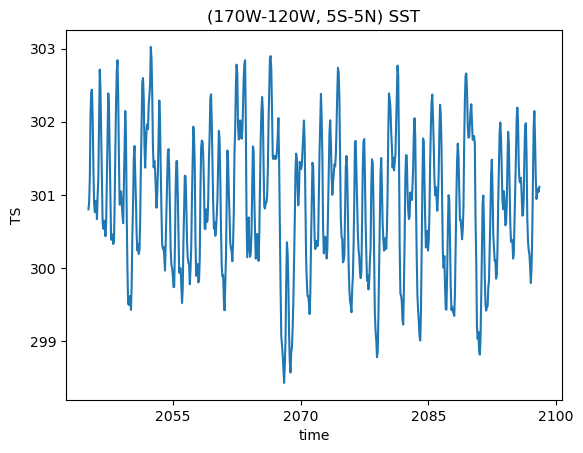

In [16]:
SST_1.plot()
plt.title('(170W-120W, 5S-5N) SST')

Text(0.5, 1.0, '(20S-20N) SST')

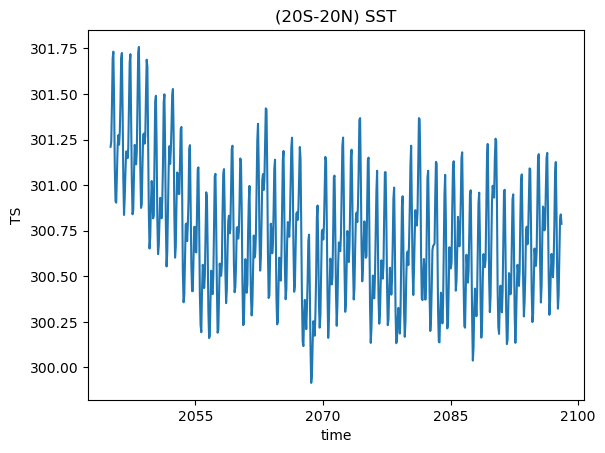

In [17]:
SST_2.plot()
plt.title('(20S-20N) SST')

Text(0.5, 1.0, 'Rel. Nino3.4')

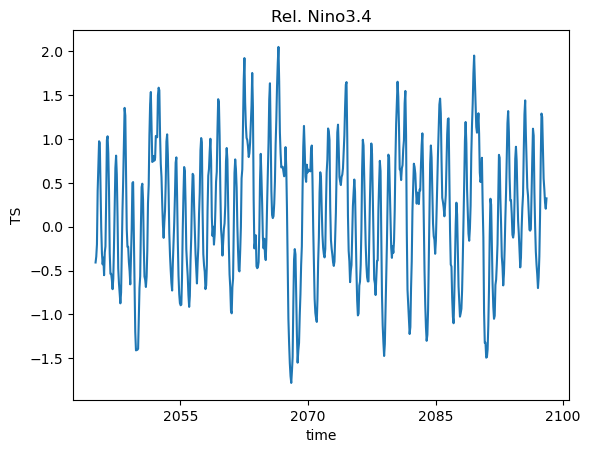

In [18]:
(SST_1 - SST_2).plot()
plt.title('Rel. Nino3.4')

Text(0.5, 1.0, 'Rel. Nino3.4')

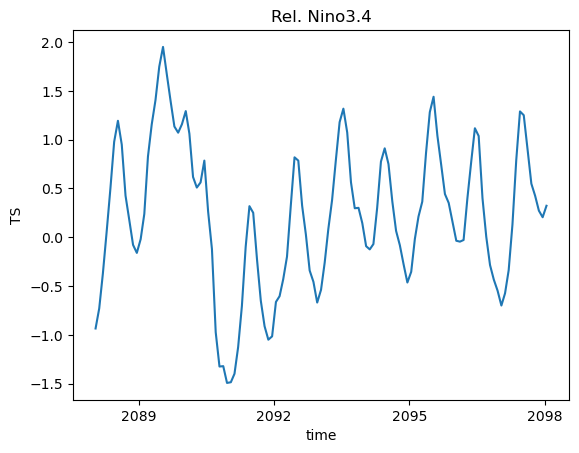

In [19]:
(SST_1 - SST_2).sel(time=slice('2088','2098')).plot()
plt.title('Rel. Nino3.4')

Text(0.5, 1.0, 'December Rel. Nino3.4')

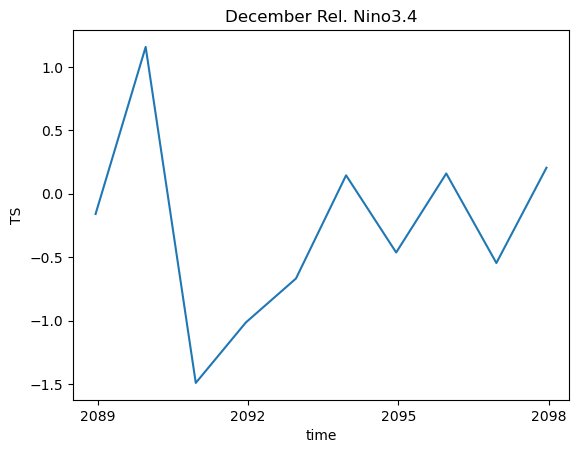

In [21]:
dSST = (SST_1 - SST_2).sel(time=slice('2088','2098'))
dSST.sel(time=dSST.time.dt.month.isin([12])).plot()
plt.title('December Rel. Nino3.4')

### Control: end - start

In [5]:
dsi = ds3.sel(time=slice('2020','2029')); label1 = 'ref'; var1 = 'tas'
dsf = ds3.sel(time=slice('2090','2099')); label2 = 'cnt'; var2 = 'tas'

# simple check to see if time.dt.month is as expected
nyears = 10 # slice end inclusive
print((dsi.time.dt.month == list(range(1,13))*nyears).all().item(), (dsf.time.dt.month == list(range(1,13))*nyears).all().item())

ds1m = {
    'annual':dsi.mean('time', keep_attrs=True),
    'DJF':dsi.isel(time=dsi.time.dt.season=='DJF').mean('time', keep_attrs=True),
    'JJA':dsi.isel(time=dsi.time.dt.season=='JJA').mean('time', keep_attrs=True)
}
ds2m = {
    'annual':dsf.mean('time', keep_attrs=True),
    'DJF':dsf.isel(time=dsf.time.dt.season=='DJF').mean('time', keep_attrs=True),
    'JJA':dsf.isel(time=dsf.time.dt.season=='JJA').mean('time', keep_attrs=True)
}

plot_kw = {'transform':ccrs.PlateCarree(), 'cmap':'cmo.thermal', 'norm':Normalize(vmin=250, vmax=310)}
diffplot_kw = {'transform':ccrs.PlateCarree(), 'cmap':'cmo.balance', 'norm':CenteredNorm()}

True True


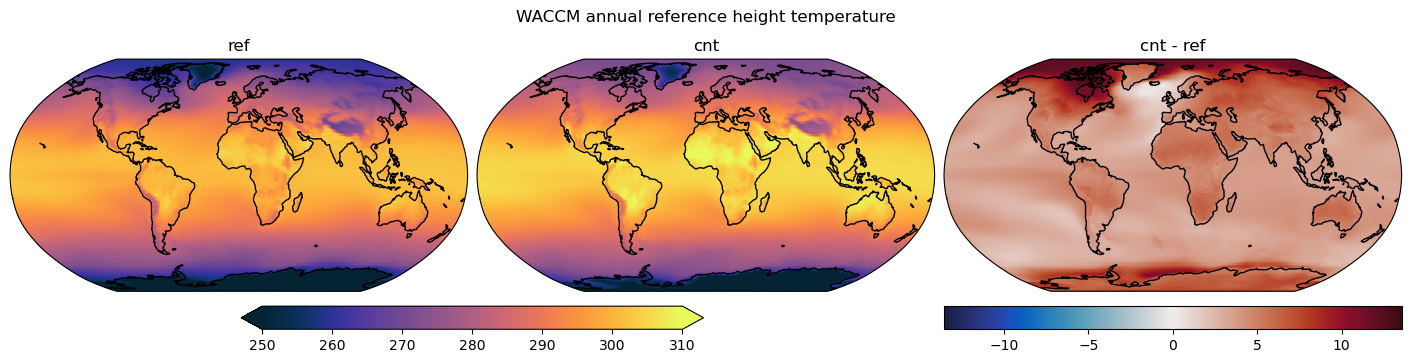

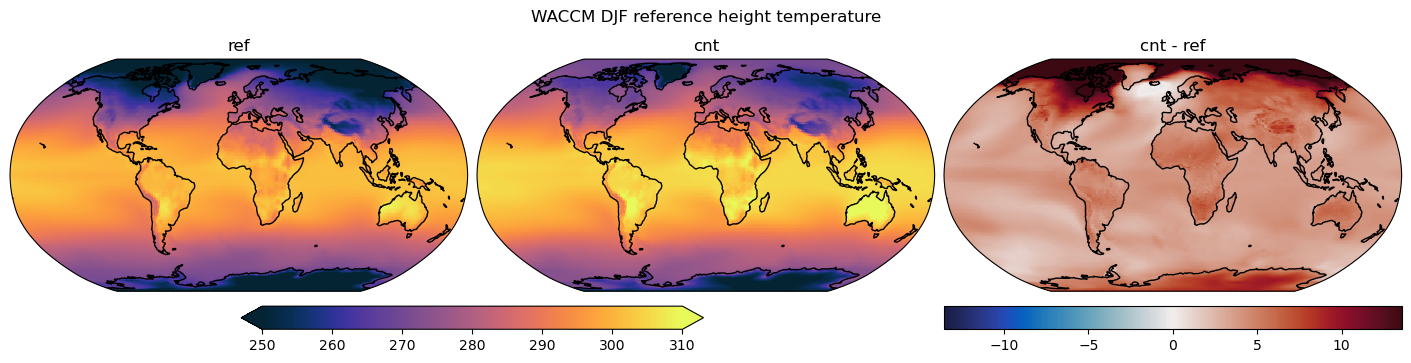

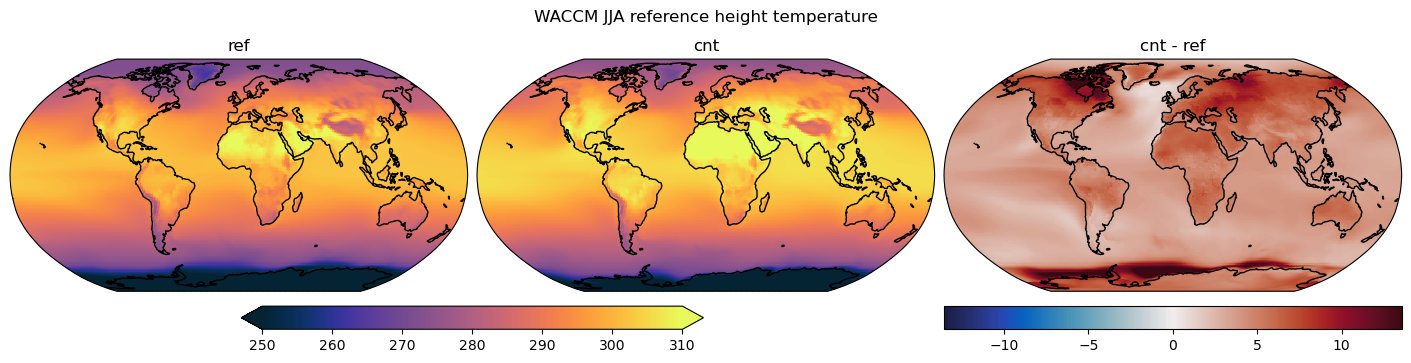

In [6]:
%matplotlib inline

for season in ['annual', 'DJF', 'JJA']:
    fig, ax = plt.subplots(1,3, figsize=(14,3.5), constrained_layout=True, subplot_kw={'projection':ccrs.Robinson()})
    Z1 = ds1m[season][var1]
    Z2 = ds2m[season][var2]
    Z3 = Z2 - Z1
    p1 = ax[0].pcolormesh(Z1.lon, Z1.lat, Z1, **plot_kw)
    p1 = ax[1].pcolormesh(Z2.lon, Z2.lat, Z2, **plot_kw)
    p3 = ax[2].pcolormesh(Z3.lon, Z3.lat, Z3, **diffplot_kw)
    plt.colorbar(p1, ax=ax[0:2], orientation='horizontal', shrink=0.5, extend='both')
    plt.colorbar(p3, ax=ax[2], orientation='horizontal')
    ax[0].set_title(f'{label1}'); ax[0].coastlines()
    ax[1].set_title(f'{label2}'); ax[1].coastlines()
    ax[2].set_title(f'{label2} - {label1}'); ax[2].coastlines()
    fig.suptitle(f'WACCM {season} reference height temperature')

### Geo: end - start

In [7]:
dsi = ds1.sel(time=slice('2020','2029')); label1 = 'ref'; var1 = 'TREFHT'
dsf = ds2.sel(time=slice('2090','2099')); label2 = 'geo'; var2 = 'TREFHT'

# simple check to see if time.dt.month is as expected
nyears = 10 # slice end inclusive
print((dsi.time.dt.month == list(range(1,13))*nyears).all().item(), (dsf.time.dt.month == list(range(1,13))*nyears).all().item())

ds1m = {
    'annual':dsi.mean('time', keep_attrs=True),
    'DJF':dsi.isel(time=dsi.time.dt.season=='DJF').mean('time', keep_attrs=True),
    'JJA':dsi.isel(time=dsi.time.dt.season=='JJA').mean('time', keep_attrs=True)
}
ds2m = {
    'annual':dsf.mean('time', keep_attrs=True),
    'DJF':dsf.isel(time=dsf.time.dt.season=='DJF').mean('time', keep_attrs=True),
    'JJA':dsf.isel(time=dsf.time.dt.season=='JJA').mean('time', keep_attrs=True)
}

plot_kw = {'transform':ccrs.PlateCarree(), 'cmap':'cmo.thermal', 'norm':Normalize(vmin=250, vmax=310)}
diffplot_kw = {'transform':ccrs.PlateCarree(), 'cmap':'cmo.balance', 'norm':CenteredNorm()}

True True


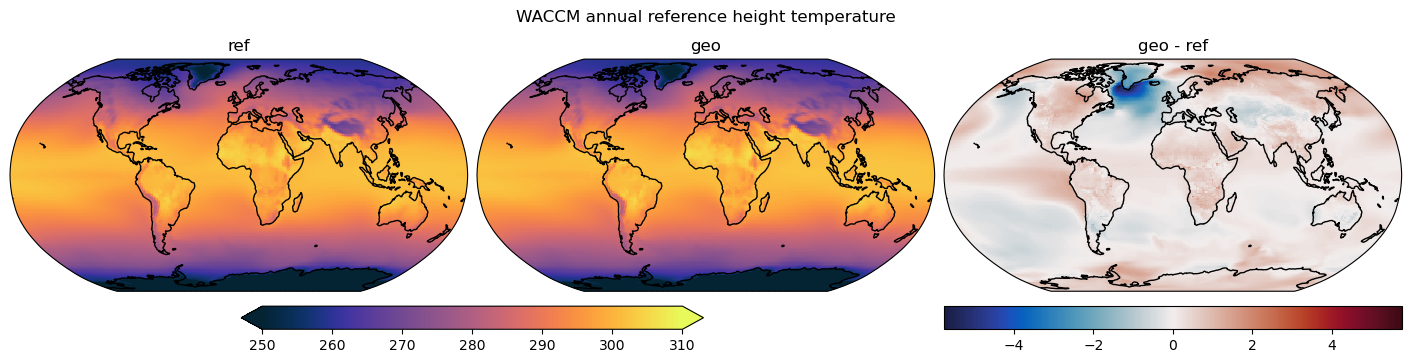

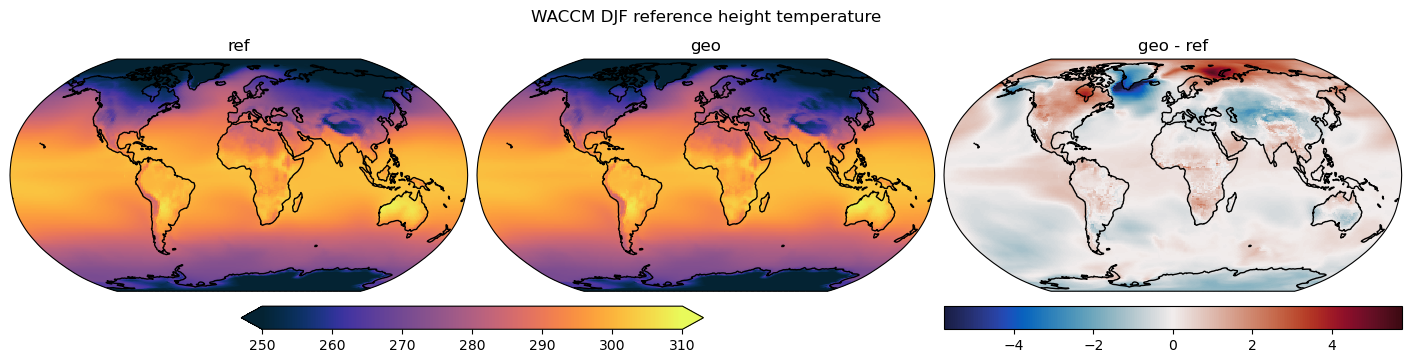

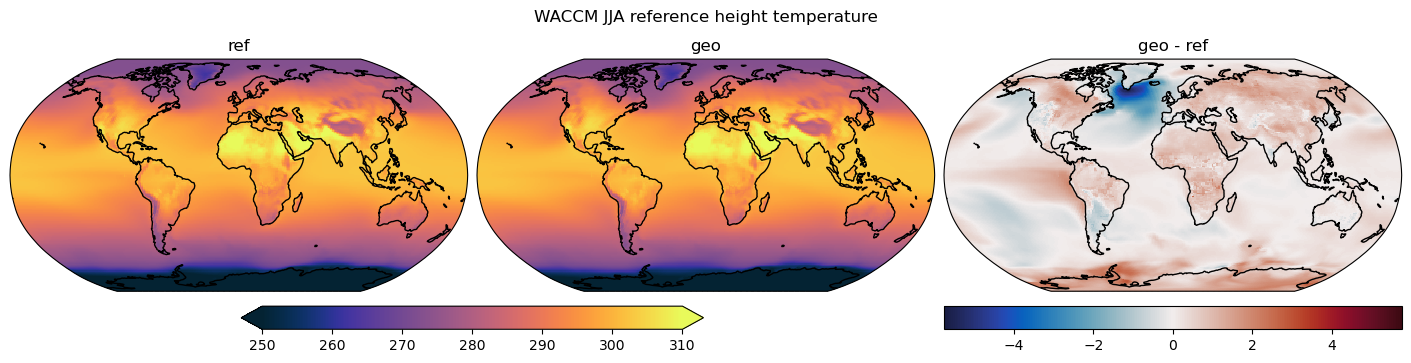

In [8]:
%matplotlib inline

for season in ['annual', 'DJF', 'JJA']:
    fig, ax = plt.subplots(1,3, figsize=(14,3.5), constrained_layout=True, subplot_kw={'projection':ccrs.Robinson()})
    Z1 = ds1m[season][var1]
    Z2 = ds2m[season][var2]
    Z3 = Z2 - Z1
    p1 = ax[0].pcolormesh(Z1.lon, Z1.lat, Z1, **plot_kw)
    p1 = ax[1].pcolormesh(Z2.lon, Z2.lat, Z2, **plot_kw)
    p3 = ax[2].pcolormesh(Z3.lon, Z3.lat, Z3, **diffplot_kw)
    plt.colorbar(p1, ax=ax[0:2], orientation='horizontal', shrink=0.5, extend='both')
    plt.colorbar(p3, ax=ax[2], orientation='horizontal')
    ax[0].set_title(f'{label1}'); ax[0].coastlines()
    ax[1].set_title(f'{label2}'); ax[1].coastlines()
    ax[2].set_title(f'{label2} - {label1}'); ax[2].coastlines()
    fig.suptitle(f'WACCM {season} reference height temperature')

### Geo end - Cnt start

In [9]:
dsi = ds3.sel(time=slice('2020','2029')); label1 = 'ref'; var1 = 'tas'
dsf = ds2.sel(time=slice('2090','2099')); label2 = 'geo'; var2 = 'TREFHT'

# simple check to see if time.dt.month is as expected
nyears = 10 # slice end inclusive
print((dsi.time.dt.month == list(range(1,13))*nyears).all().item(), (dsf.time.dt.month == list(range(1,13))*nyears).all().item())

ds1m = {
    'annual':dsi.mean('time', keep_attrs=True),
    'DJF':dsi.isel(time=dsi.time.dt.season=='DJF').mean('time', keep_attrs=True),
    'JJA':dsi.isel(time=dsi.time.dt.season=='JJA').mean('time', keep_attrs=True)
}
ds2m = {
    'annual':dsf.mean('time', keep_attrs=True),
    'DJF':dsf.isel(time=dsf.time.dt.season=='DJF').mean('time', keep_attrs=True),
    'JJA':dsf.isel(time=dsf.time.dt.season=='JJA').mean('time', keep_attrs=True)
}

plot_kw = {'transform':ccrs.PlateCarree(), 'cmap':'cmo.thermal', 'norm':Normalize(vmin=250, vmax=310)}
diffplot_kw = {'transform':ccrs.PlateCarree(), 'cmap':'cmo.balance', 'norm':CenteredNorm()}

True True


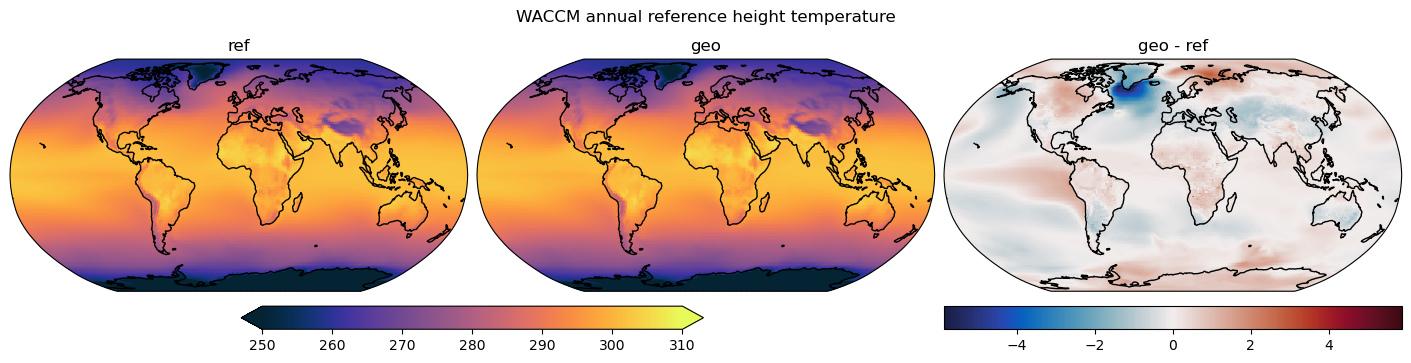

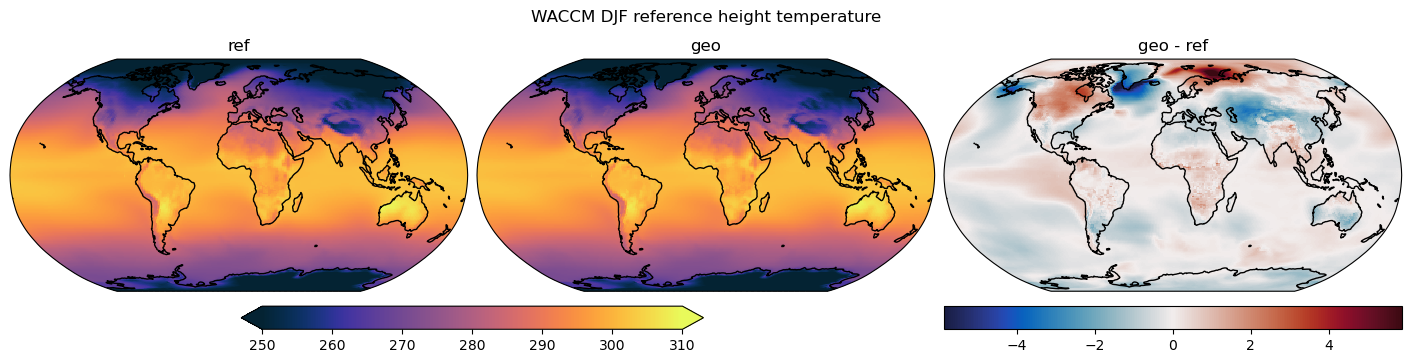

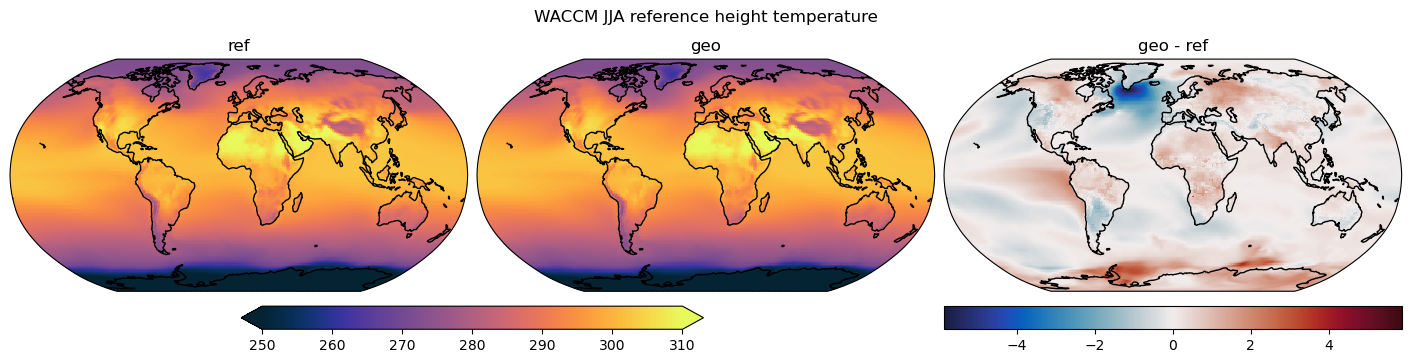

In [10]:
%matplotlib inline

for season in ['annual', 'DJF', 'JJA']:
    fig, ax = plt.subplots(1,3, figsize=(14,3.5), constrained_layout=True, subplot_kw={'projection':ccrs.Robinson()})
    Z1 = ds1m[season][var1]
    Z2 = ds2m[season][var2]
    Z3 = Z2 - Z1
    p1 = ax[0].pcolormesh(Z1.lon, Z1.lat, Z1, **plot_kw)
    p1 = ax[1].pcolormesh(Z2.lon, Z2.lat, Z2, **plot_kw)
    p3 = ax[2].pcolormesh(Z3.lon, Z3.lat, Z3, **diffplot_kw)
    plt.colorbar(p1, ax=ax[0:2], orientation='horizontal', shrink=0.5, extend='both')
    plt.colorbar(p3, ax=ax[2], orientation='horizontal')
    ax[0].set_title(f'{label1}'); ax[0].coastlines()
    ax[1].set_title(f'{label2}'); ax[1].coastlines()
    ax[2].set_title(f'{label2} - {label1}'); ax[2].coastlines()
    fig.suptitle(f'WACCM {season} reference height temperature')

In [16]:
dsm = xr.open_dataset("../jobs/globalmean/data/mres.h0.gmean.nc")

In [39]:
dsm['time2'] = ('time', dsm.time_bnds.mean('nbnd').data, dsm.time.attrs)
dsm = dsm.swap_dims({'time':'time2'}).drop_vars('time').rename({'time2':'time'})